
**[PT]** Português

---

**[EN]** English



# Alunos (evolução)

Para estimar a fiabilidade do FA é necessário comprar com números e listas nominais que 
foram obtidos directamente das fontes, sem utilizar o FA como mediação. 

Um primeiro passo consiste em traçar a evolução das entradas. 
Isso é relativamente fácil de fazer utilizando as datas iniciais nos registos. 
Os registos de remissivas do tipo "vide" não aparecem neste gráfico 
porque não têm data nos registos. 

Neste caderno, fazemos os passos para reconstituir o número de estudantes 
que entram e saem da universidade, e comparamos os resultados com os dados 
disponíveis na literatura.

---

#  Students (evolution)

To estimate the reliability of the FA it is necessary to refer to
 numbers or nominal lists that were obtained directly from the sources, without using the FA as mediation. 

A first step is to chart the evolution of intake. This is relatively easy
 to do using the initial dates on the records. The “see” type cross-reference
  records do not show in this graph because they have no date on record. 

In this notebook we go through the steps to reconstruct the number of 
students entering and exiting the university, and check the results 
with data available in the literature.

## Inicialização

---

## Setup

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from timelinknb import current_time,current_machine, get_mhk_db
import ucalumni.config as alumniconf

db_name = alumniconf.mhk_db_name
db = get_mhk_db(db_name, connect_args={'connect_timeout': 3600})
print(current_machine,current_time,f'db={db_name}')


imac-jrc 2022-05-12 13:34:11.888717 db=ucalumni


## Cobertura

---

## Coverage

Query the attributes table using attributes `uc-entrada.ano` and `uc-saida.ano`. 

These attributes have as values the year of the first date and last date on the record, as supplied
by the metadata information on the Archeevo system (fields _unitDateInitial_ and _unitDate_final_). 

Note that cross-reference records ("vide") that do not contain a valid date 
"see" references, are not included in these calculations.

In [209]:
from sqlalchemy import select, func, and_

from timelinknb import get_attribute_table
from timelinknb.config import Session

attr_table = get_attribute_table()

stmt = select(func.count(attr_table.c.entity.distinct()).label('dated_records')).\
              where(attr_table.c.the_type == 'uc-entrada.ano')

with Session() as session:
    dated_records = session.execute(stmt).scalar()      

print("Number of students with entry date", dated_records)

stmt = select(func.count(attr_table.c.entity.distinct()).label('vide_records')).\
              where(and_(attr_table.c.the_type == 'uc-entrada'),
                         attr_table.c.the_value == '0000-00-00')

with Session() as session:
    n_vide = session.execute(stmt).scalar()           


print("Number of zero date records (to be ignored)", n_vide)


Number of students with entry date 99535
Number of zero date records (to be ignored) 5763


### Estudantes e pais

Quase 50.000 estudantes são identificados com o nome do pai.

O nome de algumas mães foi adicionados a alguns registos, em resultado
da análise de certidões de idade.

---

### Students and parents

Nearly 50.000 students are identified with their father's name. 

Mother names were added to some records as a result of analysing
 some age certificates, after the original records were produced.


In [244]:
from sqlalchemy import and_, or_
from timelinknb import get_nfuncs_view 

nfuncs = get_nfuncs_view()

stmt = select(nfuncs.c['func'].label('funcao'), 
        func.count(nfuncs.c.id.distinct()).label('n')).\
            group_by("func").order_by("func")


with Session() as session:
    functions = session.execute(stmt)    

print()
print("Estudantes (n), pais (referidos) e mães (referidas)")
for f in functions:
    print(f.funcao,f.n)


Estudantes (n), pais (referidos) e mães (referidas)
n 105298
referida 93
referido 49916


### Estudantes inscritos pela primeira vez

A primeira data dos registos é usada para
estimar o número de inscritos pela
primeira vez cada ano.

---

### Students entering the university

The first date on record is used to estimate
first year students.


In [211]:
from sqlalchemy import select, func
import pandas as pd

from timelinknb import get_attribute_table
from timelinknb.config import Session

attr_table = get_attribute_table()
# Totais de estudantes por ano de entrada
stmt = select(attr_table.c.the_value.label('ano'), 
        func.count(attr_table.c.id.distinct()).label('entradas')).\
            where(attr_table.c.the_type == "uc-entrada.ano").\
            group_by("the_value").order_by("the_value")

with Session() as session:
    entradas_por_ano = session.execute(stmt)
    entradas_df = pd.DataFrame.from_records(entradas_por_ano,index=['ano'],columns=['ano','entradas'])
    entradas_df.index = entradas_df.index.astype(int)

print()
print("First values:")
print(entradas_df.head(5))
print("Last values:")
print(entradas_df.tail(5))



First values:
      entradas
ano           
1536         2
1537       201
1538       161
1539        33
1540       487
Last values:
      entradas
ano           
1913        41
1914         7
1915         4
1916         5
1917         2


### Estudantes graduados ou que abandonaram os estudos

---

### Students exiting the university

Also, by using the last year on record we can infer a date of exit from the university.
We count the exits in the year after they occurred, e.g.,the total of students with last date in
1538 is registered in 1539, meaning, they are no longer in the FA in 1539.

These number are affected by duplicate records and will improve in accuray as they are
resolved.

In [212]:
from timelinknb import get_attribute_table
from timelinknb.config import Session

# Totais de estudantes por ano de saída
stmt = select(attr_table.c.the_value.label('ano'), 
        func.count(attr_table.c.id.distinct()).label('saidas')).\
            where(attr_table.c.the_type == "uc-saida.ano").\
            group_by("the_value").order_by("the_value")

with Session() as session:
    saidas_por_ano = session.execute(stmt)
    saidas_df = pd.DataFrame.from_records(saidas_por_ano,index=['ano'],columns=['ano','saidas'])
    saidas_df.index = saidas_df.index.astype(int)

print("We consider that the student exits in the year subsequent to the last date on record")
saidas_df.index = saidas_df.index + 1
print()
print("First values:")
print(saidas_df.head(5))
print("Last values:")
print(saidas_df.tail(5))

We consider that the student exits in the year subsequent to the last date on record

First values:
      saidas
ano         
1538      84
1539      95
1540      35
1541     415
1542      80
Last values:
      saidas
ano         
1923       3
1924       2
1926       3
1927       1
1928       5


Juntamos as duas séries numa table com o número dos 
estudantes entrados e o número dos estudantes saídos
em cada ano.

---

Join the two series to obtain a table with number of students
 "entered" and number of students "exited" per year.

In [213]:

estudantes = pd.concat([entradas_df,saidas_df],axis=1).sort_index()
estudantes.fillna(0,inplace=True)
print(estudantes.info())
estudantes['presentes'] = (estudantes.entradas-estudantes.saidas).cumsum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 1536 to 1928
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entradas  391 non-null    float64
 1   saidas    391 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB
None


In [214]:

estudantes.head(5)


,entradas,saidas,presentes
ano,,,
1536,2.0,0.0,2.0
1537,201.0,0.0,203.0
1538,161.0,84.0,280.0
1539,33.0,95.0,218.0
1540,487.0,35.0,670.0


In [215]:

estudantes.tail(5)

,entradas,saidas,presentes
ano,,,
1923,0.0,3.0,12.0
1924,0.0,2.0,10.0
1926,0.0,3.0,7.0
1927,0.0,1.0,6.0
1928,0.0,5.0,1.0


# Evolução das entradas

---

# Evolution of intake

In [216]:
estudantes['entradas'].head()

ano
1536      2.0
1537    201.0
1538    161.0
1539     33.0
1540    487.0
Name: entradas, dtype: float64

## A evolução do número de primeiras inscrições na Universidade de Coimbra, 1537-1919

---

## Evolution of first year enrollments and the University of Coimbra, 1537-1919

In [217]:
plt.rcParams["figure.figsize"] = [12, 5]

<AxesSubplot:xlabel='ano'>

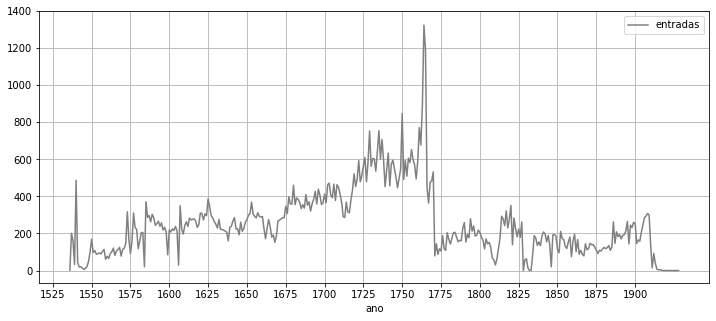

In [218]:
anos = range(1525,1921,25)
valores = range(0,1401,200)
estudantes.plot.line(color=['grey'],y='entradas',xticks=anos, yticks=valores, grid=True)

## Estimativa da população estudantil, 1537-1919

Para cada ano totalizamos o número de estudantes com a primeira data nesse ano e o 
total de estudantes com a última data nesse ano. 

O primeiro número representa os ingressos e o segundo número os estudantes 
que partirão e não estarão presentes no ano seguinte, os egressos. 
Com estes dois números é possível estimar os estudantes presentes, 
sem processar as matriculas anuais, que são complexas de extrair
fiavelmente do FA.

Os totais obtidos não correspondem aos estudantes que estariam
efecticamente presentes em Coimbra cada ano. Representam apenas
aqueles que estavam entre a sua primeira inscrição e o seu último acto
registado (quando tudo corre bem, a obtenção de um grau).

Alguns estudantes interrompiam os estudos por longo tempo, 
e estes dados não levam em conta essas situações.


---

## Estimates of student population, 1537-1919

For each year we total the number of students with the first date in that year and the 
total of students with the last date in that year. 

The first number represents the year intake and the second number the students 
that will leave and will not be present in the following year, the outtake. 
With these two numbers it is possible to estimate the students present, 
without processing the yearly matriculations, which are complex to 
extract from the FA in a reliable way.

The totals obtained do not correspond to the students who were
effectively at Coimbra. They represent those that were inbetween their first
enrolment and the last act registered in the books (hopefully graduation).

Some students would suspend enrolment for long periods of time,
but those situations are not taken into account here.

<AxesSubplot:xlabel='ano'>

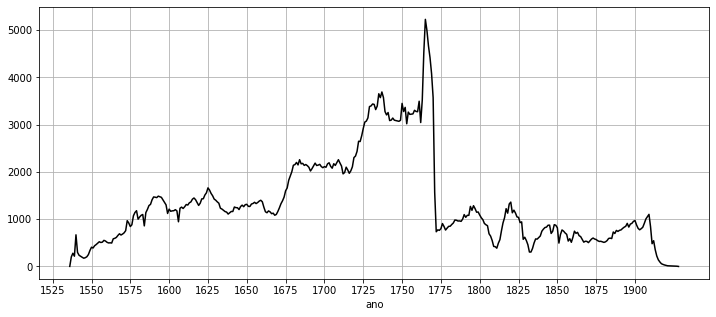

In [245]:
import matplotlib.pyplot as plt

anos = range(1525,1921,25)
estudantes['presentes'].plot(color=['black'],xticks=anos,grid=True)


## Comparando com outras estimativas

---

## Comparing with other estimates

#### Fonseca, F.T. da (2007) ‘The social and cultural roles of the University of Coimbra (1537-1820): some considerations’, e-journal of Portuguese History, Vol:5(Num:1). Available at: https://digitalis-dsp.uc.pt/jspui/handle/10316.2/25364 (Accessed: 2 April 2020).

Important: the chart is based on enrollment in Canon and Civil Law only, which corresponds to 87.3% of the total number of students, in average. "The figures used here for ‘freshmen’ in Canon and Civil Law were obtained directly from archive records (Arquivo da Universidade de Coimbra, _Livros de Matrículas_) and, for the period 1772 -1820, from Manuel Alberto Carvalho Prata, _Ciência e Sociedade. A faculdade de Filosofia no período pombalino e pós -pombalino (1772-1820)_, Guarda, 1989." p.5, n.16.


![Chart1](./images/taveira_2007_5.png)



<AxesSubplot:xlabel='ano'>

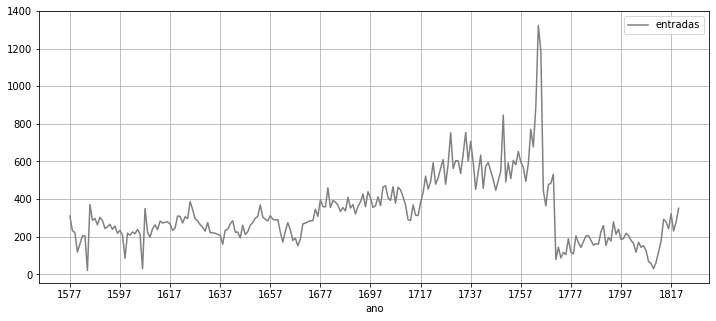

In [246]:
anos = [1577,1597,1617,1637,1657,1677,1697,1717,1737,1757,1777,1797,1817]
valores = [0,200,400,600,800,1000,1200,1400]
estudantes.loc[1577:1820].plot.line(color=['grey'], y='entradas',xticks=anos, yticks=valores,grid=True)

### Estimativas da população estudantil

---

### Estimates of student population

#### Fonseca, Fernando Taveira da. A Universidade de Coimbra 1700-1771: Estudo Social e Económico. Coimbra, 1995, pp. 31-32

In [247]:
fonseca_1995 = pd.read_csv('../extras/validation/fonseca_1995_students.csv',sep=";", index_col='Anos')
print(fonseca_1995.head())
if 'fonseca' in estudantes.columns:
    estudantes = estudantes.drop(['fonseca'],axis=1)
estudantes.loc[fonseca_1995.index.values,'fonseca'] =  fonseca_1995.values
estudantes.loc[1700:].head()

      Total
Anos       
1700   1610
1701   1664
1702   1657
1703   1750
1704   1844


,entradas,saidas,presentes,shifted,rline,perc_FA,entradas_mm_5,presentes_mm_5,fonseca
ano,,,,,,,,,
1700,412.0,389.0,2113.0,2090.0,2053.993073,0.298137,392.2,2117.2,1610.0
1701,365.0,379.0,2099.0,2113.0,2114.223835,0.269832,415.2,2133.4,1664.0
1702,464.0,392.0,2171.0,2099.0,2106.416144,0.266747,423.8,2139.4,1657.0
1703,471.0,448.0,2194.0,2171.0,2210.146900,0.240571,420.0,2132.6,1750.0
1704,407.0,481.0,2120.0,2194.0,2314.993041,0.189805,440.2,2147.6,1844.0


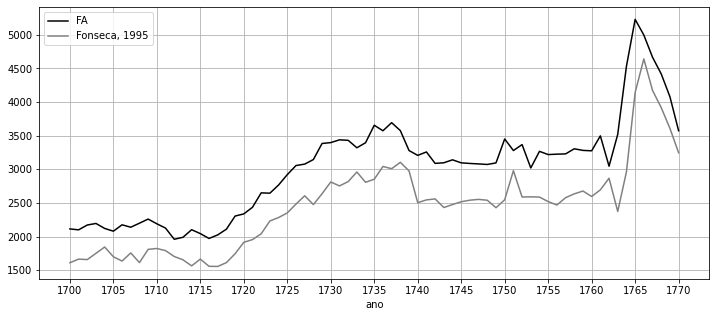

In [248]:
import matplotlib.pyplot as plt

anos = list(range(1700,1771,5))
valores = list(range(0,1401,200))
estudantes.loc[1700:1770,['presentes','fonseca']].plot(color=['black','grey'],xticks=anos,grid=True)
plt.legend(['FA','Fonseca, 1995'])

A curva do FA parece deslocada um ano para trás em relação aos dados de Fonseca. Porquê?

Desclocamos um ano para a frente.

---

The data from the FA seems to be  one year behind Fonseca, why?

We shift forward one year.

In [249]:
estudantes['shifted']=estudantes['presentes'].shift(1)

Agora estão sincronizadas.

---

Now the data is in sync.

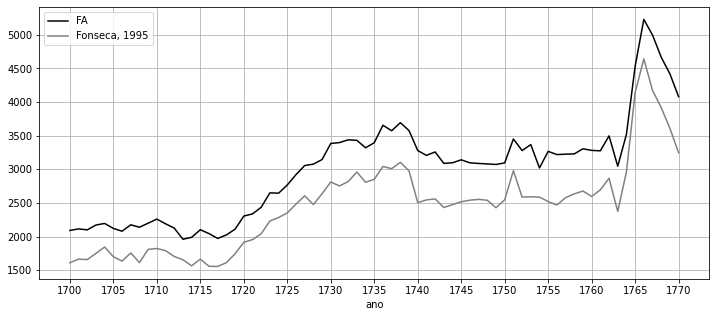

In [250]:
import matplotlib.pyplot as plt

estudantes.loc[1700:1770,['shifted','fonseca']].plot(color=['black','grey'],xticks=anos,grid=True)
plt.legend(['FA','Fonseca, 1995'])

Calcular a correlação

---

Compute de correlation

In [251]:
import numpy.polynomial.polynomial as poly

fit,residuals = poly.polyfit(estudantes.loc[1700:1770,'fonseca'],estudantes.loc[1700:1770,'shifted'],1,full=True)
eq = poly.Polynomial(fit)
if 'rline' in estudantes.columns:
    estudantes=estudantes.drop('rline',axis=1)
    
estudantes.insert(len(estudantes.columns),'rline',eq(estudantes['fonseca']))
estudantes.loc[1700:1770].head()
print(f"trend line: {eq}")

# getting the correlation coeficient is a bit complicated.
# See https://stackoverflow.com/questions/58986593/np-poly1d-how-to-calculate-r2

SSE = residuals[0]
diff = estudantes.loc[1700:1770,'fonseca'] - estudantes.loc[1700:1770,'fonseca'].mean()
square_diff = diff ** 2
SST = square_diff.sum()
R2 = 1- SSE/SST
print("Correlation coeficient",R2)

trend line: 258.22406334649156 + 1.115384478329779·x¹
Correlation coeficient [0.97414047]


Gráfico da correlação

---

Correlation graphic

y=1.12x+258.22 (r2=0.97)


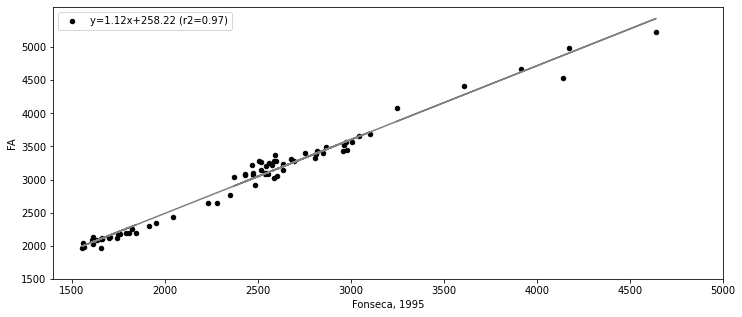

In [252]:
ax=estudantes.loc[1700:1770].plot.scatter(
                        color=['black'],
                        xticks=range(1500,5200,500),
                        yticks=range(1500,5200,500),
                        x='fonseca', 
                        y='shifted')
estudantes.loc[1700:1770].plot(
                        color=['grey'],
                        xticks=range(1500,5200,500),
                        yticks=range(1500,5200,500),
                        x='fonseca', 
                        y='rline',
                        ax=ax)
ax.set_ylabel('FA')
ax.set_xlabel('Fonseca, 1995')
m = float(list(eq)[0])
a = float(list(eq)[1])
label = f"y={a:.2f}x+{m:.2f} (r2={float(R2):.2f})"
print(label)
plt.legend([label])

Calcular a diferença percentual
das duas estimativas

---

Compute the percentual diference
of the two estimates

In [253]:
estudantes['perc_FA']=estudantes['shifted']/estudantes['fonseca']-1
estudantes.loc[1700:1770].head()

,entradas,saidas,presentes,shifted,perc_FA,entradas_mm_5,presentes_mm_5,fonseca,rline
ano,,,,,,,,,
1700,412.0,389.0,2113.0,2090.0,0.298137,392.2,2117.2,1610.0,2053.993073
1701,365.0,379.0,2099.0,2113.0,0.269832,415.2,2133.4,1664.0,2114.223835
1702,464.0,392.0,2171.0,2099.0,0.266747,423.8,2139.4,1657.0,2106.416144
1703,471.0,448.0,2194.0,2171.0,0.240571,420.0,2132.6,1750.0,2210.146900
1704,407.0,481.0,2120.0,2194.0,0.189805,440.2,2147.6,1844.0,2314.993041


Analisar a variação temporal da diferença
percentual. Existe algum padrão?

---

Analyse the evolution of the percentual
difference. Any pattern?

Average increase of estimate from FA: 0.23, max: 0.33, min: 0.094


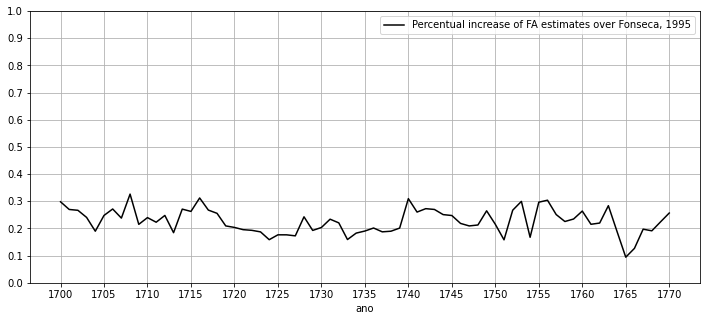

In [254]:
import numpy as np

mean_diff = estudantes.loc[1700:1770,'perc_FA'].mean()
max_diff = estudantes.loc[1700:1770,'perc_FA'].max()
min_diff = estudantes.loc[1700:1770,'perc_FA'].min()

print(f"Average increase of estimate from FA: {mean_diff:.2}, max: {max_diff:.2}, min: {min_diff:.2}")
yvalues = np.linspace(0,1,11)
estudantes.loc[1700:1770,['perc_FA']].plot(color=['black'],xticks=anos,yticks=yvalues,grid=True)
plt.legend(["Percentual increase of FA estimates over Fonseca, 1995"])

In [255]:
estudantes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 1536 to 1928
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   entradas        391 non-null    float64
 1   saidas          391 non-null    float64
 2   presentes       391 non-null    float64
 3   shifted         390 non-null    float64
 4   perc_FA         72 non-null     float64
 5   entradas_mm_5   387 non-null    float64
 6   presentes_mm_5  387 non-null    float64
 7   fonseca         72 non-null     float64
 8   rline           72 non-null     float64
dtypes: float64(9)
memory usage: 38.6 KB


## Entradas, média movel de 5 anos

--- 


## Intake, 5 year moving average

In [256]:
estudantes['entradas_mm_5']=estudantes['entradas'].rolling(window=5,center=True).mean()

<AxesSubplot:xlabel='ano'>

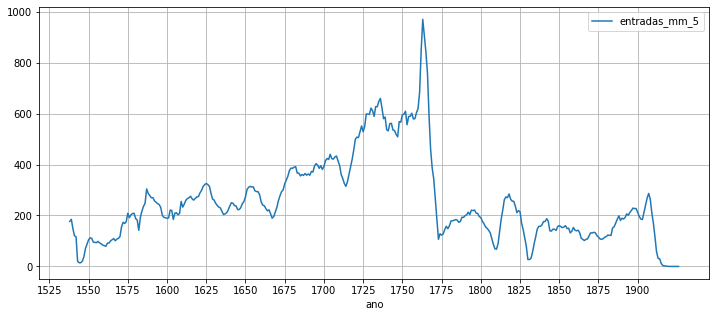

In [257]:
anos = list(range(1525,1921,25))
estudantes.plot.line(y='entradas_mm_5',xticks=anos, grid=True)

## População estudantil e reforma pombalina (1772)

---

## Student population and Pombal's reform (1772)

<AxesSubplot:xlabel='ano'>

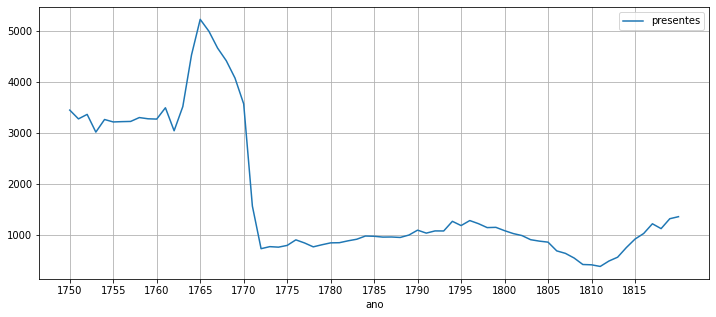

In [258]:
anos = range(1750,1820,5)
estudantes.loc[1750:1820].plot.line(y='presentes',xticks=anos, grid=True)

## União ibérica 

Portugal e Espanha unidos entre 1580 e 1640

## Iberian Union

Portugal and Spain unified between 1580 and 1640

<AxesSubplot:xlabel='ano'>

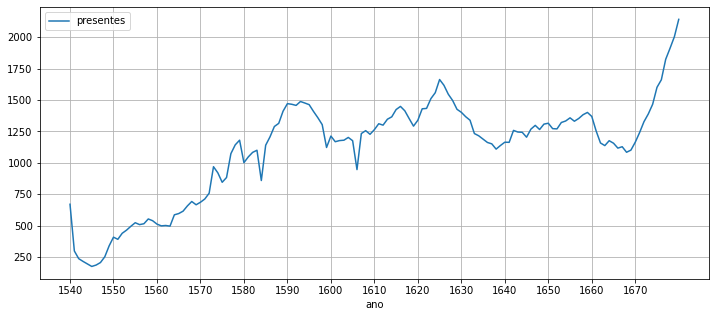

In [259]:
anos = range(1540,1680,10)
estudantes.loc[1540:1680].plot.line(y='presentes', xticks=anos, grid=True)

# Números globais

Nota: "saídas" corresponde ao total de estudantes cuja última data 
registada na documentação ocorreu no ano anterior.

Tabela guardada em inferences/students/student_pop.csv

---

# Global numbers

Note: "saidas" correspond to the total of students whose last date on record occured 
in the previous year.

Table saved to inferences/students/student_pop.csv


In [260]:
estudantes['presentes_mm_5']=estudantes['presentes'].rolling(window=5,center=True).mean()

estudantes[['entradas','saidas','presentes','entradas_mm_5','presentes_mm_5']].to_csv('../inferences/students/student_pop.csv',sep=',')

pd.set_option('display.max_rows',500)
estudantes[['entradas','saidas','presentes','entradas_mm_5','presentes_mm_5']]


,entradas,saidas,presentes,entradas_mm_5,presentes_mm_5
ano,,,,,
1536,2.0,0.0,2.0,NaN,NaN
1537,201.0,0.0,203.0,NaN,NaN
1538,161.0,84.0,280.0,176.8,274.6
1539,33.0,95.0,218.0,185.0,333.8
1540,487.0,35.0,670.0,148.6,340.6
1541,43.0,415.0,298.0,120.6,327.6
1542,19.0,80.0,237.0,116.6,323.0
1543,21.0,43.0,215.0,20.4,224.0
1544,13.0,33.0,195.0,14.4,201.6


## Mais validações (em curso)

---

## More validations (in process)

### Comparar com mapas estatísticos de Vasconcelos, primeiros anos

#### VASCONCELOS, António De - Escritos vários. Reed ed. Coimbra : Arquivo da Universidade de Coimbra, 1987


---

### Compare with Vasconcelos numbers, early years

#### VASCONCELOS, António De - Escritos vários. Reed ed. Coimbra : Arquivo da Universidade de Coimbra, 1987


In [261]:
from timelinknb.pandas import attribute_to_df


# Get list of people with a given attribute type, extra columns
alunos_1537_38 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1537',
                    person_info=True,
                    more_cols=['faculdade','faculdade-original','instituta'],)
alunos_1538_39 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1538',
                    person_info=True,
                    more_cols=['faculdade','faculdade-original','instituta'],)
alunos_1539_40 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1539',
                    person_info=True,
                    more_cols=['faculdade','faculdade-original','instituta'],)
alunos_1540_41 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1540',
                    person_info=True,
                    more_cols=['faculdade','faculdade-original','instituta'],)

alunos_1537_41 = pd.concat([alunos_1537_38,alunos_1538_39,alunos_1539_40,alunos_1540_41])

alunos_1537_41.sort_values(['uc-entrada.ano','faculdade','faculdade-original','instituta','name']).to_csv('../inferences/validation/students_1537_1548_vasconcelos.csv',sep=',')

Primeiros estudantes em Coimbra

Ficheiro em ../inferences/validation/students_1537_1548_vasconcelos.csv

---

First students at Coimbra

File at ../inferences/validation/students_1537_1548_vasconcelos.csv

In [262]:
alunos_1537_41[['uc-entrada.ano','faculdade','faculdade-original','name','faculdade.obs']].sort_values(['uc-entrada.ano','faculdade','name','faculdade.obs']).fillna("").head(5)

,uc-entrada.ano,faculdade,faculdade-original,name,faculdade.obs
id,,,,,
251448,1537,(?),,Luís Luís,
250998,1537,Artes,,Afonso Monteiro,Faculdade inferida
211383,1537,Artes,,Aires de Sá,Faculdade inferida
165741,1537,Artes,,Alexandre do Espírito Santo,Faculdade inferida
146871,1537,Artes,,António,Faculdade inferida


In [263]:
alunos_1537_41[['uc-entrada.ano','faculdade','faculdade-original','name','faculdade.obs']].sort_values(['uc-entrada.ano','faculdade','name','faculdade.obs']).fillna("").tail(5)

,uc-entrada.ano,faculdade,faculdade-original,name,faculdade.obs
id,,,,,
247379,1540,,,Miguel Fernandes,
220921,1540,,,Pedro Rodrigues,
242112,1540,,,Pedro de Sousa,
148254,1540,,,Roque de Araújo,
195743,1540,,,Tomás de Xerez,


### Reproduzir com as datas iniciais de entrada

As variações de ano para ano são semelhantes, mas os números muito diferentes.

---

### Replicate with dates of entry

Variations in time are similar, but absolute numbers not.

In [264]:
alunos_1537_41[['uc-entrada.ano','name']].groupby(['uc-entrada.ano']).count()

,name
uc-entrada.ano,
1537,207
1538,164
1539,35
1540,503


### Examinar o detalhe das inscrições

---

### Examine the detail of enrolment

![Vasconcelos. Escritos vários, 2, p.117](./images/vasconcelos_ev2_117.png)
![Vasconcelos. Escritos vários, 2, p.118](./images/vasconcelos_ev2_118.png)

Difícil comparar

---

Dificult to compare

In [265]:
original_same_as_fac = alunos_1537_41[alunos_1537_41.isnull()].index.values

alunos_1537_41.loc[original_same_as_fac,'faculdade-original'] = alunos_1537_41.loc[original_same_as_fac,'faculdade']

alunos_1537_41[['uc-entrada.ano','faculdade-original','name']].groupby(['uc-entrada.ano','faculdade-original']).count()


name
uc-entrada.ano faculdade-original                      
1537           (?)                                    1
               Artes                                 35
               Cursos jurídicos (Cânones ou Leis)     2
               Cânones                               73
               Leis                                  82
               Medicina                               7
               Teologia                               3
1538           Artes                                  5
               Cursos jurídicos (Cânones ou Leis)     1
               Cânones                               66
               Leis                                  90
               Medicina                               2
1539           Cânones                               17
               Leis                                  18
1540           (Codigo)                               1
               (Dialética)                            5
               (Granática)                            1
               (Teorico)                              2
               (Teórico)                              2
               (Teóricos)                             1
               Artes                                110
               Cursos jurídicos (Cânones ou Leis)    30
               Cânones                              117
               Leis                                 150
               Medicina                              22
               Teologia                              20
               código                                12